Found 1 eyes!
1208 1208 
Shape of Segmented Sclera: (724, 1208, 3)
k =  3
Dunn Index kmeans = 0.02931194069151013
DB Index kmeans = 0.07622137609704716
Silhouette Score kmeans= 0.9873363946510446
Calinski-Harabasz Index kmeans = 508811.0955369924
k =  4
Dunn Index kmeans = 0.013295862256820768
DB Index kmeans = 0.5299270128802644
Silhouette Score kmeans= 0.948431802102656
Calinski-Harabasz Index kmeans = 446335.7693863373

Optimum K value = 3
Dominant Color =  [251, 250, 238]


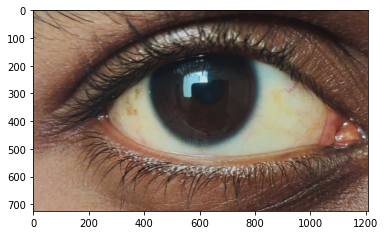

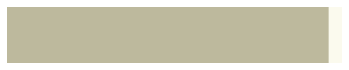

Estimated Bilirubin Value of Patient: 31.003044654939114


In [1]:
import os
import cv2
import math
import numpy as np
from PIL import Image
from validclust import dunn
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

def haarCascade(cascPath, path, haarCascadePath):

    image = cv2.imread(path)
    image_crop = Image.open(path)
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + haarCascadePath)
    eyes = eye_cascade.detectMultiScale(
        image,
        scaleFactor=1.3,
        minNeighbors=4,
    )
    print("Found {0} eyes!".format(len(eyes)))
    for (x, y, w, h) in eyes:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    plt.imshow(image)
    im_crop = image_crop.crop((x, y, (x+w), (y+h)))
    plt.imshow(im_crop)

    height = np.size(im_crop, 0)
    width = np.size(im_crop, 1)

    print(height , width, end = " ")
    im_crop2 = im_crop.crop((0 , (height/5), (width), (4*height/5)))
    plt.imshow(im_crop2)
    im_crop2.save("jay_left_1cropped.jpg")

def binarySmoothing():
    
    img = cv2.imread('jay_left_1cropped.jpg', 2)
    ret, bw_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    bw = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) # converting to its binary form
 
    cv2.imshow("Binary", bw_img)
    cv2.imwrite('jay_left_2binary.jpg',bw_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    k=20
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k ,k))
    foreground = cv2.morphologyEx(bw_img, cv2.MORPH_OPEN, kernel)
    foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)
    cv2.imshow('Cleanup up Crystal Foreground Mask', foreground)
    cv2.imwrite('jay_left_3smooth.jpg',foreground)
    cv2.waitKey()

    img = cv2.imread('jay_left_3smooth.jpg')
    blur = cv2.GaussianBlur(img, (7, 7), 2)
    h, w = img.shape[:2]
    
    return kernel, blur, img, h ,w

def morphologicalGradient(kernel,blur):

    gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)
    cv2.imshow('Morphological Gradient', gradient)
    cv2.waitKey()
    return gradient

def binarizedGradient(gradient):

    lower = np.array([0, 0, 0])
    upper = np.array([15, 15, 15])
    binary = cv2.inRange(gradient, lower, upper)
    cv2.imshow('Binarized Gradient', binary)
    cv2.waitKey()
    return binary

def floodFill(h, w, binary):
    
    # flood fill from the edges to remove edge crystals
    
    for row in range(h):
        if binary[row, 0] == 255:
            cv2.floodFill(binary, None, (0, row), 0)
        if binary[row, w-1] == 255:
            cv2.floodFill(binary, None, (w-1, row), 0)

    for col in range(w):
        if binary[0, col] == 255:
            cv2.floodFill(binary, None, (col, 0), 0)
        if binary[h-1, col] == 255:
            cv2.floodFill(binary, None, (col, h-1), 0)

    cv2.imshow('Filled Binary Gradient', binary)
    cv2.imwrite('jay_left_4filled.jpg',binary)
    cv2.waitKey()

def cleaningMask(binary, kernel):  
    
    foreground = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)
    cv2.imshow('Cleanup up Crystal Foreground Mask', foreground)
    cv2.imwrite('jay_left_5mask.jpg',foreground)
    cv2.waitKey()

    # creating background and unknown mask for labeling
    
    k1=17
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k1, k1))
    background = cv2.dilate(foreground, kernel, iterations=3)
    unknown = cv2.subtract(background, foreground)

    cv2.imshow('Background', background)
    cv2.waitKey()
    return foreground, unknown

def waterShed(img):

    markers = cv2.connectedComponents(foreground)[1]
    markers += 1  # Add one to all labels so that background is 1, not 0
    markers[unknown==255] = 0  # mark the region of unknown with zero
    markers = cv2.watershed(img, markers)

    # assign the markers a hue between 0 and 179

    hue_markers = np.uint8(179*np.float32(markers)/np.max(markers))
    blank_channel = 255*np.ones((h, w), dtype=np.uint8)
    marker_img = cv2.merge([hue_markers, blank_channel, blank_channel])
    marker_img = cv2.cvtColor(marker_img, cv2.COLOR_HSV2BGR)

    cv2.imshow('Colored Markers', marker_img)
    cv2.imwrite('jay_left_6color.jpg',marker_img)
    cv2.waitKey()

    # label the original image with the watershed markers

    labeled_img = img.copy()
    labeled_img[markers>1] = marker_img[markers>1]  # 1 is background color
    labeled_img = cv2.addWeighted(img, 0.5, labeled_img, 0.5, 0)

    cv2.imshow('Watershedding Result', labeled_img)
    cv2.imwrite('jay_left_7result.jpg',labeled_img)
    cv2.waitKey()

    img1 = cv2.imread('jay_left_1cropped.jpg')
    img5 = cv2.imread('jay_left_5mask.jpg')
    height, width, channels = img5.shape
    white = [255,255,255]
    black = [0,0,0]
    lst=[]
    for x in range(0,width):
        for y in range(0,height):
            channels_xy = img5[y,x]
            if all(channels_xy == white):    
                img5[y,x] = img1[y,x]
    cv2.imshow('Segmented Sclera',img5)
    cv2.imwrite("jay_left_8sclera.jpg", img5)
    cv2.waitKey()

def adaptiveKMeans(image):
    
    # Adaptive K Generation and Kmeans Dominant Color
    
    data = image / 255.0  # use 0...1 scale
    data = data.reshape(image.shape[0] * image.shape[1], 3)
    # print(data.shape)

    data = np.array(data)

    max_Dunn = float("-inf")
    min_DB = float("inf")
    max_Silhoutte = float("-inf")
    max_Calinski = float("-inf")

    ideal_k = k = 2

    while True:
        
        print("k = ", k + 1)
        kmeans = KMeans(n_clusters=k).fit(data)
        kmeans_labels = kmeans.labels_
        distances = pairwise_distances(data)
        Dunn = dunn(distances, kmeans_labels)
        print("Dunn Index kmeans =", Dunn)
        DB = davies_bouldin_score(data, kmeans_labels)
        print("DB Index kmeans =", DB)
        Silhoutte = silhouette_score(data, kmeans_labels)
        print('Silhouette Score kmeans=', Silhoutte)
        Calinski = metrics.calinski_harabasz_score(data, kmeans_labels)
        print('Calinski-Harabasz Index kmeans =', Calinski)

        count = 0
        if max_Dunn < Dunn:
            count += 1
        if min_DB > DB:
            count += 1
        if max_Silhoutte < Silhoutte:
            count += 1
        if max_Calinski < Calinski:
            count += 1
        if count < 2:
            break
        else:
            ideal_k = k
            k += 1
            max_Dunn = Dunn
            min_DB = DB
            max_Silhoutte = Silhoutte
            max_Calinski = Calinski

    print("\nOptimum K value =", ideal_k + 1)
    return ideal_k


def kMeansDominantColor(image_path, K):
    
    image_BRG = cv2.imread(image_path)
    image_RGB = cv2.cvtColor(image_BRG, cv2.COLOR_BGR2RGB)

    image_reshaped = image_RGB.reshape((image_RGB.shape[0] * image_RGB.shape[1], 3))
    clt = KMeans(n_clusters=K)  # + 1)
    clt.fit(image_reshaped)

    def centroidHistogram(clt):
        
        # grab the number of different clusters and create a histogram based on the number of pixels assigned to each cluster
        numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
        (hist, _) = np.histogram(clt.labels_, bins=numLabels)
        # normalize the histogram, such that it sums to one
        hist = hist.astype("float")
        hist /= hist.sum()
        # return the histogram
        return hist

    def plotColors(hist, centroids):
        
        # initialize the bar chart representing the relative frequency of each of the colors
        bar = np.zeros((50, 300, 3), dtype="uint8")
        startX = 0
        # loop over the percentage of each cluster and the color of each cluster
        for (percent, color) in zip(hist, centroids):
            # plot the relative percentage of each cluster
            endX = startX + (percent * 300)
            cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                         color.astype("uint8").tolist(), -1)
            startX = endX

        # return the bar chart
        return bar

    def dominantColor(hist, centroids):
        
        Max_percent = float("-inf")
        max_val = max(hist)
        for (percent, color) in zip(hist, centroids):
            # plot the relative percentage of each cluster
            if Max_percent < percent != max_val:
                Max_percent = percent
                dom_color = color.astype("uint8").tolist()
        return dom_color

    hist= centroidHistogram(clt)
    m= max(hist)
    s=sum(hist)-m
    hist1=[]
    b=0
    for i in hist:
        b+=1
        if i==m:
            y=b
            continue
        else:
            a=i/s
            hist1.append(a)
    clt1=[]
    b=0
    for i in clt.cluster_centers_:
        b+=1
        if b==y:
            continue
        else:
            clt1.append(i)
    hist=hist1
    bar = plotColors(hist, clt1)
    dominantColor = dominantColor(hist, clt1)
    print("Dominant Color = ", dominantColor)
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.savefig('jaundicebc2_10bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    return dominantColor

def bilirubinQuantification():
    
    storeRGBValues = []
    image = cv2.imread('jay_left_8sclera.jpg')
    height, width, channels = image.shape
    print("\nShape of Segmented Sclera: ",end="")
    print(image.shape)
    if width>100:
        x= width//100
        image1 = cv2.resize(image, (width//x, height//x))
    else:
        image1 = cv2.resize(image, (width, height))
    ideal_k_1 = adaptiveKMeans(image1)
    cv2.imshow('Resized Sclera', image1)
    cv2.imwrite('jay_left_9resize.jpg',image1)
    cv2.waitKey()
    storeRGBValues.append(kMeansDominantColor('jay_left_8sclera.jpg', ideal_k_1 + 1))

    red=storeRGBValues[0][0]
    green=storeRGBValues[0][1]
    blue=storeRGBValues[0][2]
    yellow= blue/(red+green+blue)
    biliRubin = 0.46*red-0.32*green-0.01*blue-37.22*yellow+9.91
    print("Estimated Bilirubin Value of Patient: ",end="")
    print(biliRubin)
    

cascPath = "haarcascade_eye.xml"
path = "jay_left.jpg"
haarCascadePath= "haarcascade_eye.xml"
haarCascade(cascPath, path, haarCascadePath)
kernel, blur, img, h, w = binarySmoothing()
gradient = morphologicalGradient(kernel, blur)
binary = binarizedGradient(gradient)
floodFill(h, w, binary)
foreground, unknown = cleaningMask(binary, kernel)
waterShed(img)
bilirubinQuantification()